In [1]:
# 필요한 패키지 설치
# !pip install transformers torch torchvision scikit-learn pillow matplotlib

# MPS (Apple Silicon) 지원 확인
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")

# 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS 디바이스 사용")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA 디바이스 사용")
else:
    device = torch.device("cpu")
    print("CPU 디바이스 사용")


PyTorch 버전: 2.5.1
CUDA 사용 가능: False
MPS 사용 가능: True
MPS 디바이스 사용


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import EfficientNetForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from PIL import Image
import torchvision.transforms as transforms
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 데이터 경로 및 라벨 설정
data_path = "../data/dogs-vs-cats/imagenette"

imagenette_sample = [
    {'sea slug, nudibranch':'n01945685_slug.jpeg'},
    {'conch':'n01943899_conch.jpeg'},
    {'slug':'n01945685_slug.jpeg'},
    {'flatworm, platyhelminth':'n01924916_flatworm.jpeg'},
    {'chiton, coat-of-mail shell, sea cradle, polyplacophore':'n01955084_chiton.jpeg'},
    {'isopod':'n01990800_isopod.jpeg'},
    {'rugby ball':'n04118538_rugby_ball.jpeg'}
]

# label로 파일명을 찾는 함수
def get_imagenette_filename(label):
    for d in imagenette_sample:
        if label == list(d.keys())[0]:
            return d[label]
    return None

def show_predictions(pred_imgs, data_path="../data/dogs-vs-cats/imagenette"):
    fig, axes = plt.subplots(1, len(pred_imgs), figsize=(20, 5))
    for ax, pred in zip(axes, pred_imgs):
        label = pred['label']
        score = pred['score']
        print(label, score)
        filename = get_imagenette_filename(label)
        if filename is None:
            print(f"label {label}에 해당하는 파일 없음")
            continue
        img_png = Image.open(f"{data_path}/{filename}")
        ax.imshow(img_png)
        ax.axis('off')
        ax.set_title(f"{label}\n{float(score):.3f}", fontsize=12)
    plt.tight_layout()
    plt.show()

In [3]:
#!gdown 10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo


(600, 600, 3)


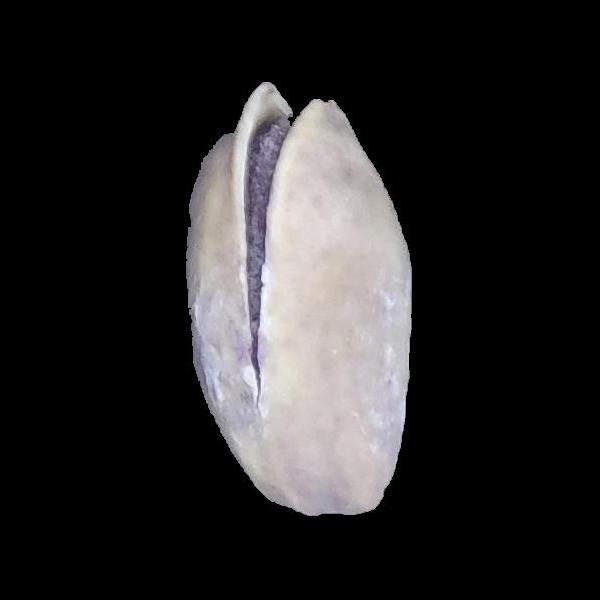

In [4]:
# 샘플 이미지 확인
import numpy as np
from PIL import Image

sample_path = "../data/Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg"
pistachio_sample = np.array(Image.open(sample_path))

print(pistachio_sample.shape)

display(Image.open(sample_path))

Device set to use mps:0


chiton, coat-of-mail shell, sea cradle, polyplacophore 0.36714306473731995
conch 0.0803556963801384
rugby ball 0.03670297935605049
flatworm, platyhelminth 0.03588511422276497
isopod 0.0227279644459486


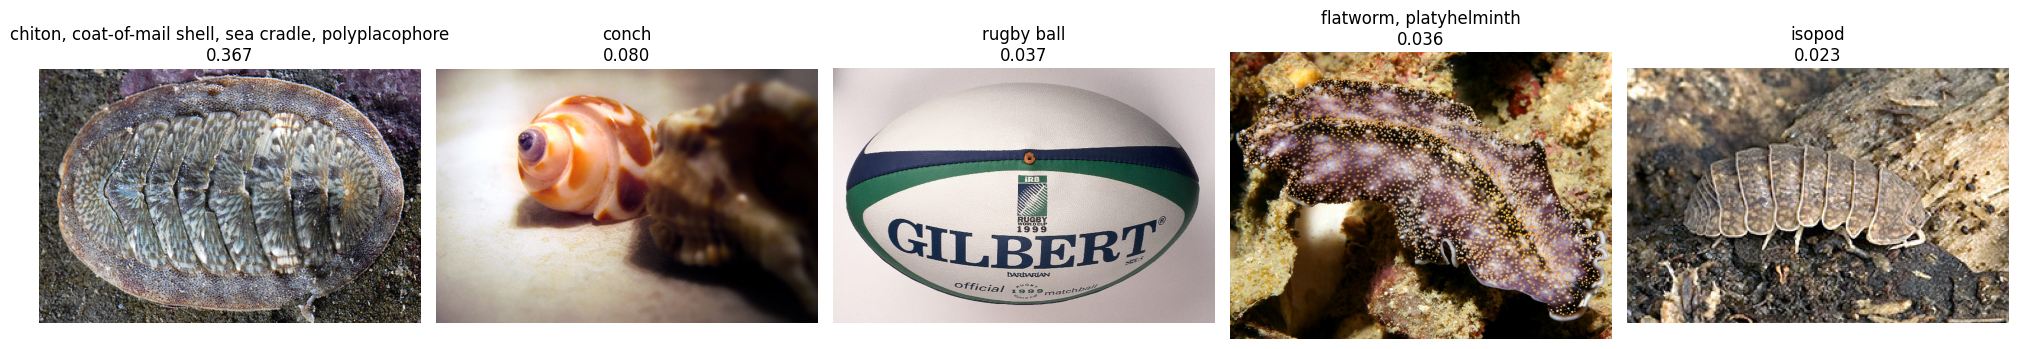

In [5]:
# 파인튜닝을 하기전 예측
import torch
from transformers import pipeline, EfficientNetImageProcessor, EfficientNetForImageClassification 

preprocessor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")
efficientb7 = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0")

pipe = pipeline(task="image-classification", model="google/efficientnet-b0", processor=preprocessor)

pred_imgs = pipe(sample_path)

# print(pred_imgs)
show_predictions(pred_imgs)


In [6]:
# Huggingface로 파인튜닝 (Keras X)
from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, EfficientNetForImageClassification, TrainingArguments, Trainer
import numpy as np
from PIL import Image

# 데이터셋 로드 (Huggingface datasets 사용)
dataset = load_dataset(
    "imagefolder",
    data_dir="../data/Pistachio_Image_Dataset",
    split={"train": "train[:80%]", "validation": "train[80%:]"},
    cache_dir="./hf_cache"
)
dataset = DatasetDict(dataset)


Resolving data files:   0%|          | 0/2149 [00:00<?, ?it/s]

In [7]:
pred_imgs

[{'label': 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
  'score': 0.36714306473731995},
 {'label': 'conch', 'score': 0.0803556963801384},
 {'label': 'rugby ball', 'score': 0.03670297935605049},
 {'label': 'flatworm, platyhelminth', 'score': 0.03588511422276497},
 {'label': 'isopod', 'score': 0.0227279644459486}]

In [8]:
dataset 

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1718
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 430
    })
})

In [9]:
# 클래스 라벨 추출
labels = dataset["train"].features["label"].names
labels

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [11]:
# 전처리 함수 정의
image_processor = AutoImageProcessor.from_pretrained("google/efficientnet-b0")

def preprocess(example):
    image = example["image"].convert("RGB")
    inputs = image_processor(image, return_tensors="pt")
    example["pixel_values"] = inputs["pixel_values"].squeeze()
    example["label"] = example["label"]
    return example

dataset = dataset.map(preprocess)#, remove_columns=["image"])

# 모델 준비
model = EfficientNetForImageClassification.from_pretrained(
    "google/efficientnet-b0",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: i for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True  # 이 줄 추가
)

per_device_train_batch_size = 32
total_steps_per_epoch = len(dataset["train"]) // per_device_train_batch_size
steps_for_01_epoch = int(total_steps_per_epoch * 1)

# Trainer로 파인튜닝
training_args = TrainingArguments(
    output_dir="efficientnet-b0-finetuned_0805_3",
    eval_strategy="epoch",
    save_strategy="epoch",
    eval_steps=steps_for_01_epoch,
    save_steps=steps_for_01_epoch,
    learning_rate=2e-4,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_train_batch_size,
    num_train_epochs=20,
    remove_unused_columns=False,
    logging_steps=steps_for_01_epoch//4,
    logging_strategy="steps",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True
)

def collate_fn(batch):
    pixel_values = []
    labels = []
    
    for x in batch:
        if isinstance(x["pixel_values"], torch.Tensor):
            pixel_values.append(x["pixel_values"])
        else:
            pixel_values.append(torch.tensor(x["pixel_values"]))
        labels.append(x["label"])
    
    return {
        "pixel_values": torch.stack(pixel_values),
        "labels": torch.tensor(labels)
    }

from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# 🔥 확실한 Train 메트릭 추적 커스텀 트레이너
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_eval_in_progress = False
    
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        # 기본 validation 평가 실행
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        # validation 평가 완료 후, train dataset도 평가 (무한루프 방지)
        if (eval_dataset is None and  # validation 평가일 때
            metric_key_prefix == "eval" and 
            not self.train_eval_in_progress and
            self.state.global_step > 0):
            
            print(f"🔍 Step {self.state.global_step}: 훈련 데이터도 평가 중...")
            self.train_eval_in_progress = True
            
            try:
                # train dataset 평가
                train_metrics = super().evaluate(
                    eval_dataset=self.train_dataset,
                    ignore_keys=ignore_keys,
                    metric_key_prefix="train"
                )
                
                # train 메트릭을 로그 히스토리에 추가
                train_metrics['epoch'] = self.state.epoch
                train_metrics['step'] = self.state.global_step
                self.state.log_history.append(train_metrics)
                
                print(f"   ✅ Train Loss: {train_metrics.get('train_loss', 'N/A'):.4f}, Accuracy: {train_metrics.get('train_accuracy', 'N/A'):.3f}")
                
            except Exception as e:
                print(f"   ❌ Train 평가 중 오류: {e}")
            finally:
                self.train_eval_in_progress = False
        
        return metrics

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=collate_fn,
    processing_class=image_processor,
    compute_metrics=compute_metrics
)




Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
trainer.train()



  0%|          | 0/1080 [00:00<?, ?it/s]

{'loss': 0.448, 'grad_norm': 1.4371651411056519, 'learning_rate': 0.0001975925925925926, 'epoch': 0.24}
{'loss': 0.1221, 'grad_norm': 3.4032413959503174, 'learning_rate': 0.0001951851851851852, 'epoch': 0.48}
{'loss': 0.0802, 'grad_norm': 2.53831148147583, 'learning_rate': 0.0001927777777777778, 'epoch': 0.72}
{'loss': 0.0879, 'grad_norm': 0.10837722569704056, 'learning_rate': 0.00019037037037037037, 'epoch': 0.96}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.009444082155823708, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 15.7434, 'eval_samples_per_second': 27.313, 'eval_steps_per_second': 0.889, 'epoch': 1.0}
🔍 Step 54: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.15199972689151764, 'train_accuracy': 0.9412107101280559, 'train_f1': 0.9426973886720132, 'train_runtime': 60.9153, 'train_samples_per_second': 28.203, 'train_steps_per_second': 0.886, 'epoch': 1.0}
   ✅ Train Loss: 0.1520, Accuracy: 0.941
{'loss': 0.0605, 'grad_norm': 0.11871837824583054, 'learning_rate': 0.00018796296296296296, 'epoch': 1.2}
{'loss': 0.0175, 'grad_norm': 0.052965398877859116, 'learning_rate': 0.00018555555555555556, 'epoch': 1.44}
{'loss': 0.0651, 'grad_norm': 4.861025810241699, 'learning_rate': 0.00018314814814814816, 'epoch': 1.69}
{'loss': 0.0148, 'grad_norm': 0.12795235216617584, 'learning_rate': 0.00018074074074074075, 'epoch': 1.93}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.007185991853475571, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 15.5986, 'eval_samples_per_second': 27.566, 'eval_steps_per_second': 0.898, 'epoch': 2.0}
🔍 Step 108: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.027844438329339027, 'train_accuracy': 0.9912689173457508, 'train_f1': 0.9913033789812639, 'train_runtime': 62.1485, 'train_samples_per_second': 27.643, 'train_steps_per_second': 0.869, 'epoch': 2.0}
   ✅ Train Loss: 0.0278, Accuracy: 0.991
{'loss': 0.0127, 'grad_norm': 0.09507136791944504, 'learning_rate': 0.00017833333333333335, 'epoch': 2.17}
{'loss': 0.046, 'grad_norm': 0.08121509104967117, 'learning_rate': 0.00017592592592592595, 'epoch': 2.41}
{'loss': 0.0168, 'grad_norm': 0.07007427513599396, 'learning_rate': 0.00017351851851851851, 'epoch': 2.65}
{'loss': 0.021, 'grad_norm': 0.532123327255249, 'learning_rate': 0.0001711111111111111, 'epoch': 2.89}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.019533343613147736, 'eval_accuracy': 0.9953488372093023, 'eval_f1': 0.9976689976689976, 'eval_runtime': 15.7609, 'eval_samples_per_second': 27.283, 'eval_steps_per_second': 0.888, 'epoch': 3.0}
🔍 Step 162: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.0012461597798392177, 'train_accuracy': 0.9994179278230501, 'train_f1': 0.9994177461622223, 'train_runtime': 65.7065, 'train_samples_per_second': 26.147, 'train_steps_per_second': 0.822, 'epoch': 3.0}
   ✅ Train Loss: 0.0012, Accuracy: 0.999
{'loss': 0.0042, 'grad_norm': 0.038972001522779465, 'learning_rate': 0.0001687037037037037, 'epoch': 3.13}
{'loss': 0.0064, 'grad_norm': 0.024365903809666634, 'learning_rate': 0.0001662962962962963, 'epoch': 3.37}
{'loss': 0.017, 'grad_norm': 0.03340822458267212, 'learning_rate': 0.0001638888888888889, 'epoch': 3.61}
{'loss': 0.0044, 'grad_norm': 0.022170718759298325, 'learning_rate': 0.0001614814814814815, 'epoch': 3.85}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.01978049986064434, 'eval_accuracy': 0.9953488372093023, 'eval_f1': 0.9976689976689976, 'eval_runtime': 15.9149, 'eval_samples_per_second': 27.019, 'eval_steps_per_second': 0.88, 'epoch': 4.0}
🔍 Step 216: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.002838923130184412, 'train_accuracy': 0.9988358556461001, 'train_f1': 0.9988365780211906, 'train_runtime': 62.4327, 'train_samples_per_second': 27.518, 'train_steps_per_second': 0.865, 'epoch': 4.0}
   ✅ Train Loss: 0.0028, Accuracy: 0.999
{'loss': 0.0107, 'grad_norm': 0.8656712174415588, 'learning_rate': 0.0001590740740740741, 'epoch': 4.09}
{'loss': 0.012, 'grad_norm': 3.9106695652008057, 'learning_rate': 0.00015666666666666666, 'epoch': 4.33}
{'loss': 0.0013, 'grad_norm': 0.02297087386250496, 'learning_rate': 0.00015425925925925926, 'epoch': 4.57}
{'loss': 0.0092, 'grad_norm': 0.0762622281908989, 'learning_rate': 0.00015185185185185185, 'epoch': 4.81}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.016468526795506477, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 15.2403, 'eval_samples_per_second': 28.215, 'eval_steps_per_second': 0.919, 'epoch': 5.0}
🔍 Step 270: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.0027265066746622324, 'train_accuracy': 0.9988358556461001, 'train_f1': 0.9988358556461001, 'train_runtime': 61.1917, 'train_samples_per_second': 28.076, 'train_steps_per_second': 0.882, 'epoch': 5.0}
   ✅ Train Loss: 0.0027, Accuracy: 0.999
{'loss': 0.0186, 'grad_norm': 0.003782490501180291, 'learning_rate': 0.00014944444444444445, 'epoch': 5.06}
{'loss': 0.0038, 'grad_norm': 0.023761451244354248, 'learning_rate': 0.00014703703703703705, 'epoch': 5.3}
{'loss': 0.0148, 'grad_norm': 0.003041980555281043, 'learning_rate': 0.00014462962962962962, 'epoch': 5.54}
{'loss': 0.0035, 'grad_norm': 0.265852153301239, 'learning_rate': 0.00014222222222222224, 'epoch': 5.78}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.06551146507263184, 'eval_accuracy': 0.9767441860465116, 'eval_f1': 0.9882352941176471, 'eval_runtime': 15.5507, 'eval_samples_per_second': 27.652, 'eval_steps_per_second': 0.9, 'epoch': 6.0}
🔍 Step 324: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.001092705293558538, 'train_accuracy': 0.9994179278230501, 'train_f1': 0.9994177461622223, 'train_runtime': 62.7197, 'train_samples_per_second': 27.392, 'train_steps_per_second': 0.861, 'epoch': 6.0}
   ✅ Train Loss: 0.0011, Accuracy: 0.999
{'loss': 0.0021, 'grad_norm': 0.11141932010650635, 'learning_rate': 0.0001398148148148148, 'epoch': 6.02}
{'loss': 0.0031, 'grad_norm': 0.010506431572139263, 'learning_rate': 0.0001374074074074074, 'epoch': 6.26}
{'loss': 0.001, 'grad_norm': 0.3018853962421417, 'learning_rate': 0.00013500000000000003, 'epoch': 6.5}
{'loss': 0.0026, 'grad_norm': 0.006841742899268866, 'learning_rate': 0.0001325925925925926, 'epoch': 6.74}
{'loss': 0.0037, 'grad_norm': 0.4973486065864563, 'learning_rate': 0.0001301851851851852, 'epoch': 6.98}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08984984457492828, 'eval_accuracy': 0.9744186046511628, 'eval_f1': 0.9870435806831567, 'eval_runtime': 15.8874, 'eval_samples_per_second': 27.065, 'eval_steps_per_second': 0.881, 'epoch': 7.0}
🔍 Step 378: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.0005237953155301511, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 63.7991, 'train_samples_per_second': 26.928, 'train_steps_per_second': 0.846, 'epoch': 7.0}
   ✅ Train Loss: 0.0005, Accuracy: 1.000
{'loss': 0.0012, 'grad_norm': 0.002892408287152648, 'learning_rate': 0.00012777777777777776, 'epoch': 7.22}
{'loss': 0.0008, 'grad_norm': 0.001345012802630663, 'learning_rate': 0.0001253703703703704, 'epoch': 7.46}
{'loss': 0.0526, 'grad_norm': 0.08363080769777298, 'learning_rate': 0.00012296296296296296, 'epoch': 7.7}
{'loss': 0.0053, 'grad_norm': 0.04395367577672005, 'learning_rate': 0.00012055555555555555, 'epoch': 7.94}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.14276279509067535, 'eval_accuracy': 0.9604651162790697, 'eval_f1': 0.9798339264531435, 'eval_runtime': 16.079, 'eval_samples_per_second': 26.743, 'eval_steps_per_second': 0.871, 'epoch': 8.0}
🔍 Step 432: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.0003503770858515054, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 64.6971, 'train_samples_per_second': 26.555, 'train_steps_per_second': 0.835, 'epoch': 8.0}
   ✅ Train Loss: 0.0004, Accuracy: 1.000
{'loss': 0.0017, 'grad_norm': 0.03737016022205353, 'learning_rate': 0.00011814814814814816, 'epoch': 8.19}
{'loss': 0.0013, 'grad_norm': 0.007093136664479971, 'learning_rate': 0.00011574074074074075, 'epoch': 8.43}
{'loss': 0.001, 'grad_norm': 0.006239250302314758, 'learning_rate': 0.00011333333333333334, 'epoch': 8.67}
{'loss': 0.0034, 'grad_norm': 0.0025392372626811266, 'learning_rate': 0.00011092592592592592, 'epoch': 8.91}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.040321722626686096, 'eval_accuracy': 0.9930232558139535, 'eval_f1': 0.9964994165694282, 'eval_runtime': 16.0887, 'eval_samples_per_second': 26.727, 'eval_steps_per_second': 0.87, 'epoch': 9.0}
🔍 Step 486: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.002707570791244507, 'train_accuracy': 0.9994179278230501, 'train_f1': 0.9994181087719142, 'train_runtime': 65.309, 'train_samples_per_second': 26.306, 'train_steps_per_second': 0.827, 'epoch': 9.0}
   ✅ Train Loss: 0.0027, Accuracy: 0.999
{'loss': 0.001, 'grad_norm': 0.0965779572725296, 'learning_rate': 0.00010851851851851853, 'epoch': 9.15}
{'loss': 0.006, 'grad_norm': 0.0012929108925163746, 'learning_rate': 0.00010611111111111112, 'epoch': 9.39}
{'loss': 0.0062, 'grad_norm': 0.00416425708681345, 'learning_rate': 0.0001037037037037037, 'epoch': 9.63}
{'loss': 0.0003, 'grad_norm': 0.046001825481653214, 'learning_rate': 0.00010129629629629631, 'epoch': 9.87}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.03555088862776756, 'eval_accuracy': 0.9930232558139535, 'eval_f1': 0.9964994165694282, 'eval_runtime': 16.126, 'eval_samples_per_second': 26.665, 'eval_steps_per_second': 0.868, 'epoch': 10.0}
🔍 Step 540: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.00011388972052372992, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 65.532, 'train_samples_per_second': 26.216, 'train_steps_per_second': 0.824, 'epoch': 10.0}
   ✅ Train Loss: 0.0001, Accuracy: 1.000
{'loss': 0.0036, 'grad_norm': 0.004014355596154928, 'learning_rate': 9.888888888888889e-05, 'epoch': 10.11}
{'loss': 0.0001, 'grad_norm': 0.0035659840796142817, 'learning_rate': 9.648148148148149e-05, 'epoch': 10.35}
{'loss': 0.0003, 'grad_norm': 0.0019571392331272364, 'learning_rate': 9.407407407407408e-05, 'epoch': 10.59}
{'loss': 0.0004, 'grad_norm': 0.0028872110415250063, 'learning_rate': 9.166666666666667e-05, 'epoch': 10.83}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.020991245284676552, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.3597, 'eval_samples_per_second': 26.284, 'eval_steps_per_second': 0.856, 'epoch': 11.0}
🔍 Step 594: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.00028720288537442684, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 65.7715, 'train_samples_per_second': 26.121, 'train_steps_per_second': 0.821, 'epoch': 11.0}
   ✅ Train Loss: 0.0003, Accuracy: 1.000
{'loss': 0.0004, 'grad_norm': 0.0012027694610878825, 'learning_rate': 8.925925925925926e-05, 'epoch': 11.07}
{'loss': 0.0002, 'grad_norm': 0.0008375404286198318, 'learning_rate': 8.685185185185185e-05, 'epoch': 11.31}
{'loss': 0.0003, 'grad_norm': 0.005401692818850279, 'learning_rate': 8.444444444444444e-05, 'epoch': 11.56}
{'loss': 0.0003, 'grad_norm': 0.003836493706330657, 'learning_rate': 8.203703703703704e-05, 'epoch': 11.8}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.031159106642007828, 'eval_accuracy': 0.9953488372093023, 'eval_f1': 0.9976689976689976, 'eval_runtime': 16.5559, 'eval_samples_per_second': 25.973, 'eval_steps_per_second': 0.846, 'epoch': 12.0}
🔍 Step 648: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 4.0717579395277426e-05, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 65.7891, 'train_samples_per_second': 26.114, 'train_steps_per_second': 0.821, 'epoch': 12.0}
   ✅ Train Loss: 0.0000, Accuracy: 1.000
{'loss': 0.0003, 'grad_norm': 0.001376464730128646, 'learning_rate': 7.962962962962964e-05, 'epoch': 12.04}
{'loss': 0.0057, 'grad_norm': 0.0014880497474223375, 'learning_rate': 7.722222222222223e-05, 'epoch': 12.28}
{'loss': 0.0045, 'grad_norm': 0.08373327553272247, 'learning_rate': 7.481481481481481e-05, 'epoch': 12.52}
{'loss': 0.0006, 'grad_norm': 0.23752406239509583, 'learning_rate': 7.240740740740741e-05, 'epoch': 12.76}
{'loss': 0.0024, 'grad_norm': 0.30642685294151306, 'learning_rate': 7e-05, 'epoch': 13.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.020356472581624985, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.5795, 'eval_samples_per_second': 25.936, 'eval_steps_per_second': 0.844, 'epoch': 13.0}
🔍 Step 702: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.000361803628038615, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 66.1177, 'train_samples_per_second': 25.984, 'train_steps_per_second': 0.817, 'epoch': 13.0}
   ✅ Train Loss: 0.0004, Accuracy: 1.000
{'loss': 0.0007, 'grad_norm': 0.00048244319623336196, 'learning_rate': 6.759259259259259e-05, 'epoch': 13.24}
{'loss': 0.0002, 'grad_norm': 0.06916676461696625, 'learning_rate': 6.51851851851852e-05, 'epoch': 13.48}
{'loss': 0.0003, 'grad_norm': 0.3677719533443451, 'learning_rate': 6.277777777777778e-05, 'epoch': 13.72}
{'loss': 0.0003, 'grad_norm': 0.0003970906836912036, 'learning_rate': 6.037037037037038e-05, 'epoch': 13.96}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.120457723736763, 'eval_accuracy': 0.9674418604651163, 'eval_f1': 0.983451536643026, 'eval_runtime': 16.378, 'eval_samples_per_second': 26.255, 'eval_steps_per_second': 0.855, 'epoch': 14.0}
🔍 Step 756: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 9.305272396886721e-05, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 66.2775, 'train_samples_per_second': 25.921, 'train_steps_per_second': 0.815, 'epoch': 14.0}
   ✅ Train Loss: 0.0001, Accuracy: 1.000
{'loss': 0.0001, 'grad_norm': 0.005087834317237139, 'learning_rate': 5.796296296296296e-05, 'epoch': 14.2}
{'loss': 0.0001, 'grad_norm': 0.0017767344834282994, 'learning_rate': 5.555555555555556e-05, 'epoch': 14.44}
{'loss': 0.0001, 'grad_norm': 0.0009541552281007171, 'learning_rate': 5.314814814814815e-05, 'epoch': 14.69}
{'loss': 0.0001, 'grad_norm': 0.0014155064709484577, 'learning_rate': 5.0740740740740744e-05, 'epoch': 14.93}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.02634432353079319, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.4897, 'eval_samples_per_second': 26.077, 'eval_steps_per_second': 0.849, 'epoch': 15.0}
🔍 Step 810: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.0004952598246745765, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 66.169, 'train_samples_per_second': 25.964, 'train_steps_per_second': 0.816, 'epoch': 15.0}
   ✅ Train Loss: 0.0005, Accuracy: 1.000
{'loss': 0.0001, 'grad_norm': 0.015498064458370209, 'learning_rate': 4.8333333333333334e-05, 'epoch': 15.17}
{'loss': 0.0001, 'grad_norm': 0.0018276771297678351, 'learning_rate': 4.592592592592593e-05, 'epoch': 15.41}
{'loss': 0.0013, 'grad_norm': 0.0017053638584911823, 'learning_rate': 4.351851851851852e-05, 'epoch': 15.65}
{'loss': 0.0015, 'grad_norm': 0.003804465290158987, 'learning_rate': 4.111111111111111e-05, 'epoch': 15.89}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.029870102182030678, 'eval_accuracy': 0.9953488372093023, 'eval_f1': 0.9976689976689976, 'eval_runtime': 16.4716, 'eval_samples_per_second': 26.106, 'eval_steps_per_second': 0.85, 'epoch': 16.0}
🔍 Step 864: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.001523183542303741, 'train_accuracy': 0.9988358556461001, 'train_f1': 0.9988358556461001, 'train_runtime': 66.4363, 'train_samples_per_second': 25.859, 'train_steps_per_second': 0.813, 'epoch': 16.0}
   ✅ Train Loss: 0.0015, Accuracy: 0.999
{'loss': 0.0002, 'grad_norm': 0.0014238142175599933, 'learning_rate': 3.8703703703703705e-05, 'epoch': 16.13}
{'loss': 0.0001, 'grad_norm': 0.0004875873273704201, 'learning_rate': 3.62962962962963e-05, 'epoch': 16.37}
{'loss': 0.0001, 'grad_norm': 0.0008395312470383942, 'learning_rate': 3.388888888888889e-05, 'epoch': 16.61}
{'loss': 0.0006, 'grad_norm': 0.00036795923369936645, 'learning_rate': 3.148148148148148e-05, 'epoch': 16.85}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.02322324551641941, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.3768, 'eval_samples_per_second': 26.257, 'eval_steps_per_second': 0.855, 'epoch': 17.0}
🔍 Step 918: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.0009296236094087362, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 66.3512, 'train_samples_per_second': 25.893, 'train_steps_per_second': 0.814, 'epoch': 17.0}
   ✅ Train Loss: 0.0009, Accuracy: 1.000
{'loss': 0.0009, 'grad_norm': 0.00036839439417235553, 'learning_rate': 2.9074074074074077e-05, 'epoch': 17.09}
{'loss': 0.0001, 'grad_norm': 0.0006194391171447933, 'learning_rate': 2.6666666666666667e-05, 'epoch': 17.33}
{'loss': 0.002, 'grad_norm': 0.0008844522526487708, 'learning_rate': 2.425925925925926e-05, 'epoch': 17.57}
{'loss': 0.0001, 'grad_norm': 0.0005554837989620864, 'learning_rate': 2.1851851851851852e-05, 'epoch': 17.81}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.030365917831659317, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.4352, 'eval_samples_per_second': 26.163, 'eval_steps_per_second': 0.852, 'epoch': 18.0}
🔍 Step 972: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 5.0261693104403093e-05, 'train_accuracy': 1.0, 'train_f1': 1.0, 'train_runtime': 66.222, 'train_samples_per_second': 25.943, 'train_steps_per_second': 0.815, 'epoch': 18.0}
   ✅ Train Loss: 0.0001, Accuracy: 1.000
{'loss': 0.0002, 'grad_norm': 0.0006020228611305356, 'learning_rate': 1.9444444444444445e-05, 'epoch': 18.06}
{'loss': 0.0001, 'grad_norm': 0.0018589466344565153, 'learning_rate': 1.7037037037037038e-05, 'epoch': 18.3}
{'loss': 0.0005, 'grad_norm': 0.0004112044698558748, 'learning_rate': 1.462962962962963e-05, 'epoch': 18.54}
{'loss': 0.0003, 'grad_norm': 0.03641699627041817, 'learning_rate': 1.2222222222222222e-05, 'epoch': 18.78}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.02232414297759533, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.4023, 'eval_samples_per_second': 26.216, 'eval_steps_per_second': 0.854, 'epoch': 19.0}
🔍 Step 1026: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.004063955042511225, 'train_accuracy': 0.9988358556461001, 'train_f1': 0.9988365780211906, 'train_runtime': 66.0548, 'train_samples_per_second': 26.009, 'train_steps_per_second': 0.818, 'epoch': 19.0}
   ✅ Train Loss: 0.0041, Accuracy: 0.999
{'loss': 0.0002, 'grad_norm': 0.00028416651184670627, 'learning_rate': 9.814814814814815e-06, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.0005827344721183181, 'learning_rate': 7.4074074074074075e-06, 'epoch': 19.26}
{'loss': 0.0001, 'grad_norm': 0.0010899767512455583, 'learning_rate': 5e-06, 'epoch': 19.5}
{'loss': 0.0002, 'grad_norm': 0.0010931658325716853, 'learning_rate': 2.5925925925925925e-06, 'epoch': 19.74}
{'loss': 0.0001, 'grad_norm': 0.0006975377327762544, 'learning_rate': 1.851851851851852e-07, 'epoch': 19.98}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.023508599027991295, 'eval_accuracy': 0.9976744186046511, 'eval_f1': 0.9988358556461001, 'eval_runtime': 16.4152, 'eval_samples_per_second': 26.195, 'eval_steps_per_second': 0.853, 'epoch': 20.0}
🔍 Step 1080: 훈련 데이터도 평가 중...


  0%|          | 0/54 [00:00<?, ?it/s]

{'train_loss': 0.004125684965401888, 'train_accuracy': 0.9976717112922002, 'train_f1': 0.9976717112922002, 'train_runtime': 66.5451, 'train_samples_per_second': 25.817, 'train_steps_per_second': 0.811, 'epoch': 20.0}
   ✅ Train Loss: 0.0041, Accuracy: 0.998
{'train_runtime': 3055.7601, 'train_samples_per_second': 11.244, 'train_steps_per_second': 0.353, 'train_loss': 0.014698877657604128, 'epoch': 20.0}


TrainOutput(global_step=1080, training_loss=0.014698877657604128, metrics={'train_runtime': 3055.7601, 'train_samples_per_second': 11.244, 'train_steps_per_second': 0.353, 'total_flos': 1.244451520585728e+17, 'train_loss': 0.014698877657604128, 'epoch': 20.0})

=== 학습 로그 분석 중... ===
총 로그 엔트리: 144개
📈 Train 데이터 포인트: 40개
📈 Validation 데이터 포인트: 20개
🔍 Train 길이 체크: epochs(40), loss(40), acc(40)
🔍 Val 길이 체크: epochs(20), loss(20), acc(20)


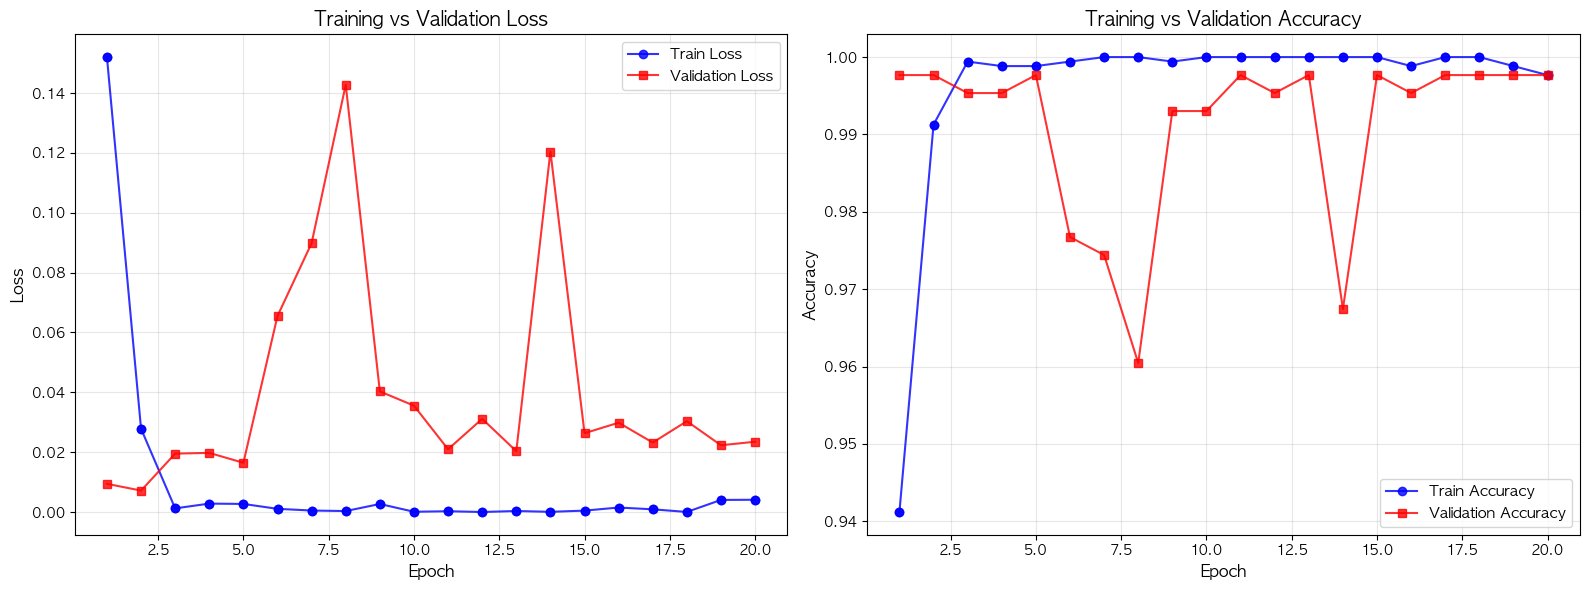


📊 최종 학습 성능 요약
🔹 Train Loss:      0.0041
🔹 Validation Loss: 0.0235
🔹 Train Accuracy:  99.77%
🔹 Val Accuracy:    99.77%

🔍 과적합 진단:
   Loss 차이:     +0.0194 (Val - Train)
   Accuracy 차이: -0.00% (Train - Val)

🟢 결론: ✅ 우수한 일반화 성능

🏆 최고 검증 정확도: 99.77% (Epoch 1.0)


In [13]:
# 📊 Train vs Validation 학습 곡선 분석
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

print("=== 학습 로그 분석 중... ===")

# 1. 로그 히스토리에서 메트릭 추출 (안전한 방식)
logs = trainer.state.log_history

print(f"총 로그 엔트리: {len(logs)}개")

# Train 메트릭과 Validation 메트릭을 분리하여 추출
train_data = []
val_data = []

for log in logs:
    # Train 메트릭이 있는 로그 (train_loss와 train_accuracy가 모두 있어야 함)
    if 'train_loss' in log and 'train_accuracy' in log and 'epoch' in log:
        train_data.append({
            'epoch': log['epoch'],
            'loss': log['train_loss'],
            'accuracy': log['train_accuracy']
        })
    
    # Validation 메트릭이 있는 로그 (train 메트릭이 없는 것만)
    elif 'eval_loss' in log and 'eval_accuracy' in log and 'epoch' in log and 'train_loss' not in log:
        val_data.append({
            'epoch': log['epoch'],
            'loss': log['eval_loss'],
            'accuracy': log['eval_accuracy']
        })

# 데이터 정렬 (epoch 순서대로)
train_data.sort(key=lambda x: x['epoch'])
val_data.sort(key=lambda x: x['epoch'])

# 리스트로 변환
train_epochs = [d['epoch'] for d in train_data]
train_loss = [d['loss'] for d in train_data]
train_accuracy = [d['accuracy'] for d in train_data]

val_epochs = [d['epoch'] for d in val_data]
val_loss = [d['loss'] for d in val_data]
val_accuracy = [d['accuracy'] for d in val_data]

print(f"📈 Train 데이터 포인트: {len(train_loss)}개")
print(f"📈 Validation 데이터 포인트: {len(val_loss)}개")
print(f"🔍 Train 길이 체크: epochs({len(train_epochs)}), loss({len(train_loss)}), acc({len(train_accuracy)})")
print(f"🔍 Val 길이 체크: epochs({len(val_epochs)}), loss({len(val_loss)}), acc({len(val_accuracy)})")

# 2. 학습 곡선 그래프
plt.figure(figsize=(16, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
if train_loss and train_epochs:
    plt.plot(train_epochs, train_loss, 'o-', label='Train Loss', color='blue', markersize=6, alpha=0.8)
if val_loss and val_epochs:
    plt.plot(val_epochs, val_loss, 's-', label='Validation Loss', color='red', markersize=6, alpha=0.8)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Accuracy 그래프
plt.subplot(1, 2, 2)
if train_accuracy and train_epochs:
    plt.plot(train_epochs, train_accuracy, 'o-', label='Train Accuracy', color='blue', markersize=6, alpha=0.8)
if val_accuracy and val_epochs:
    plt.plot(val_epochs, val_accuracy, 's-', label='Validation Accuracy', color='red', markersize=6, alpha=0.8)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 성능 분석 및 과적합 진단
if train_loss and val_loss and train_accuracy and val_accuracy:
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    final_train_acc = train_accuracy[-1]
    final_val_acc = val_accuracy[-1]
    
    print("\n" + "="*50)
    print("📊 최종 학습 성능 요약")
    print("="*50)
    print(f"🔹 Train Loss:      {final_train_loss:.4f}")
    print(f"🔹 Validation Loss: {final_val_loss:.4f}")
    print(f"🔹 Train Accuracy:  {final_train_acc:.2%}")
    print(f"🔹 Val Accuracy:    {final_val_acc:.2%}")
    
    # 과적합 진단
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc
    
    print(f"\n🔍 과적합 진단:")
    print(f"   Loss 차이:     {loss_gap:+.4f} (Val - Train)")
    print(f"   Accuracy 차이: {acc_gap:+.2%} (Train - Val)")
    
    # 진단 결과
    if abs(acc_gap) < 0.02:  # 2% 미만
        status = "✅ 우수한 일반화 성능"
        color = "🟢"
    elif abs(acc_gap) < 0.05:  # 5% 미만
        status = "✅ 좋은 일반화 성능"
        color = "🟢"
    elif abs(acc_gap) < 0.10:  # 10% 미만
        status = "⚠️ 경미한 과적합"
        color = "🟡"
    elif abs(acc_gap) < 0.20:  # 20% 미만
        status = "⚠️ 중간 수준 과적합"
        color = "🟡"
    else:
        status = "🚨 심각한 과적합"
        color = "🔴"
    
    print(f"\n{color} 결론: {status}")
    
    # 최고 성능 찾기
    if val_accuracy:
        best_val_acc = max(val_accuracy)
        best_epoch = val_epochs[val_accuracy.index(best_val_acc)]
        print(f"\n🏆 최고 검증 정확도: {best_val_acc:.2%} (Epoch {best_epoch:.1f})")
        
else:
    print("\n⚠️ Train 메트릭이 충분하지 않습니다.")
    print("다음 학습에서는 전체 과정이 기록될 것입니다.")
